# Alex Fick Final Project 

## Hyperparameter Tuning (don't run this)

In [380]:
import pandas as pd
params1 = pd.DataFrame(columns=['rmindfs', 'rmaxdfs', 'rmaxfts', 'smindfs', 'smaxdfs', 'smaxfts', 'accuracy'])
params2 = pd.DataFrame(columns=['rmindfs', 'rmaxdfs', 'rmaxfts', 'smindfs', 'smaxdfs', 'smaxfts', 'accuracy'])
params3 = pd.DataFrame(columns=['rmindfs', 'rmaxdfs', 'rmaxfts', 'smindfs', 'smaxdfs', 'smaxfts', 'accuracy'])
params4 = pd.DataFrame(columns=['rmindfs', 'rmaxdfs', 'rmaxfts', 'smindfs', 'smaxdfs', 'smaxfts', 'accuracy'])

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from scipy.sparse import hstack
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Step 1: Load the Data
data = pd.read_csv('Training.csv')
testdata = pd.read_csv('Test.csv')

# Step 2: Preprocess the Data
data = data[['overall', 'reviewText', 'summary', 'verified']]

def label_rating(row, cutoff):
    if row['overall'] > cutoff:
        return 1  # Good review
    else:
        return 0  # Bad review

# Step 3: Split the Data into Training and Testing Sets
cutoff = [2]

review_mindfs = np.linspace(0, 0.05, 5)
summary_mindfs = np.linspace(0, 0.05, 5)
review_maxdfs = np.linspace(0.1, 0.6, 6)
summary_maxdfs = np.linspace(0.1, 0.6, 6)
review_maxfts = np.linspace(500, 4500, 5, dtype = int)
summary_maxfts = np.linspace(300, 3000, 5, dtype = int)

bestParams1 = []
bestParams2 = []
bestParams3 = []
bestParams4 = []

# for min, max, ft, smin, smax, sft in zip(review_mindfs, review_maxdfs, review_maxfts, summary_mindfs, summary_maxdfs, summary_maxfts):
for c in cutoff:
    best = 0

    best_rmindfs = 0
    best_rmaxdfs = 0
    best_rmaxfts = 0
    best_smindfs = 0
    best_smaxdfs = 0
    best_smaxfts = 0

    prev_accuracy = 0

    for min in review_mindfs:
        for max in review_maxdfs: 
            for ft in review_maxfts: 
                for smin in summary_mindfs:
                    for smax in summary_maxdfs: 
                        for sft in summary_maxfts: 
                            if max < min:
                                continue
                            if smax < smin: 
                                continue

                            data['label'] = data.apply(lambda row: label_rating(row, c), axis=1)

                            # Filter out samples with only one class
                            grouped_data = data.groupby('label')
                            filtered_data = grouped_data.filter(lambda x: len(x) > 1)

                            X_train, X_test, y_train, y_test = train_test_split(
                                filtered_data[['reviewText', 'summary', 'verified']],
                                filtered_data['label'],
                                test_size=0.2,
                                random_state=42)

                            X_test['summary'] = X_test['summary'].fillna('')
                            X_train['summary'] = X_train['summary'].fillna('')

                            # Step 4: Create Feature Vectors using Sklearn Vectorizers
                            vectorizer_review = TfidfVectorizer(min_df=min, max_df=max, max_features=ft)
                            vectorizer_summary = TfidfVectorizer(min_df=smin, max_df=smax, max_features=sft)

                            X_train_review_vectorized = vectorizer_review.fit_transform(X_train['reviewText'])
                            X_train_summary_vectorized = vectorizer_summary.fit_transform(X_train['summary'])
                            X_train_verified = X_train['verified'].astype(int).values.reshape(-1, 1)

                            X_test_review_vectorized = vectorizer_review.transform(X_test['reviewText'])
                            X_test_summary_vectorized = vectorizer_summary.transform(X_test['summary'])
                            X_test_verified = X_test['verified'].astype(int).values.reshape(-1, 1)

                            # Combine the vectorized features
                            X_train_vectorized = hstack([X_train_review_vectorized, X_train_summary_vectorized, X_train_verified])
                            X_test_vectorized = hstack([X_test_review_vectorized, X_test_summary_vectorized, X_test_verified])

                            # Step 5: Train and Evaluate the Logistic Regression Model
                            model = LogisticRegression()
                            model.fit(X_train_vectorized, y_train)

                            # Predict labels for the test set
                            y_pred = model.predict(X_test_vectorized)

                            # Vectorize the test data for prediction
                            # test_review_vectorized = vectorizer_review.transform(testdata['reviewText'])
                            # testdata['summary'] = testdata['summary'].fillna('')  # Fill NaN values with empty string
                            # test_summary_vectorized = vectorizer_summary.transform(testdata['summary'])
                            # test_verified = testdata['verified'].astype(int).values.reshape(-1, 1)
                            # test_combined_vectorized = hstack([test_review_vectorized, test_summary_vectorized, test_verified])

                            # # Predict labels for the test set
                            # kaggle_test = model.predict(test_combined_vectorized)
                            # Calculate accuracy
                            accuracy = f1_score(y_test, y_pred, average = 'macro')
                            accuracy = cross_val_score(model, X_train_vectorized, y_train, cv=5, scoring='f1_macro').mean()
                            if c == 1:
                                params1.loc[len(params1.index)] = [min, max, ft, smin, smax, sft, accuracy]
                            elif c == 2:
                                params2.loc[len(params2.index)] = [min, max, ft, smin, smax, sft, accuracy]
                            elif c == 3:
                                params3.loc[len(params3.index)] = [min, max, ft, smin, smax, sft, accuracy]
                            elif c == 4:
                                params4.loc[len(params4.index)] = [min, max, ft, smin, smax, sft, accuracy]
                            if accuracy > best: 
                                best = accuracy
                                best_rmindfs = min
                                best_rmaxdfs = max
                                best_rmaxfts = ft
                                best_smindfs = smin
                                best_smaxdfs = smax
                                best_smaxfts = sft
                                if c == 1: 
                                    bestParams1 = [min, max, ft, smin, smax, sft, accuracy]
                                elif c == 2: 
                                    bestParams2 = [min, max, ft, smin, smax, sft, accuracy]
                                elif c == 3: 
                                    bestParams3 = [min, max, ft, smin, smax, sft, accuracy]
                                elif c == 4: 
                                    bestParams4 = [min, max, ft, smin, smax, sft, accuracy]


params1.to_csv('crossval_tuning/crossval_scores_cutoff_1.csv')
params2.to_csv('crossval_tuning/crossval_scores_cutoff_2.csv')
params3.to_csv('crossval_tuning/crossval_scores_cutoff_3.csv')
params4.to_csv('crossval_tuning/crossval_scores_cutoff_4.csv')
                        

KeyboardInterrupt: 

## Binary Classification Task

** Cutoff: 1 **
Accuracy: 0.8544021925316889
Params: 0.0, 0.6, 1500, 0.0, 0.1, 975
Confusion Matrix:
[[ 688  545]
 [ 305 4300]]


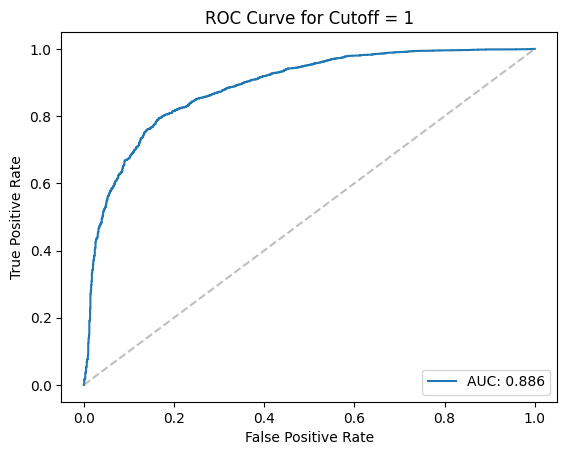

Macro F1 Score: 0.7641010282519717
Cross-Validation Accuracy: 0.8591494377123965
-------------------------
** Cutoff: 2 **
Accuracy: 0.828023295649195
Params: 0.0, 0.3, 1250, 0.0, 0.3, 1250
Confusion Matrix:
[[1858  523]
 [ 481 2976]]


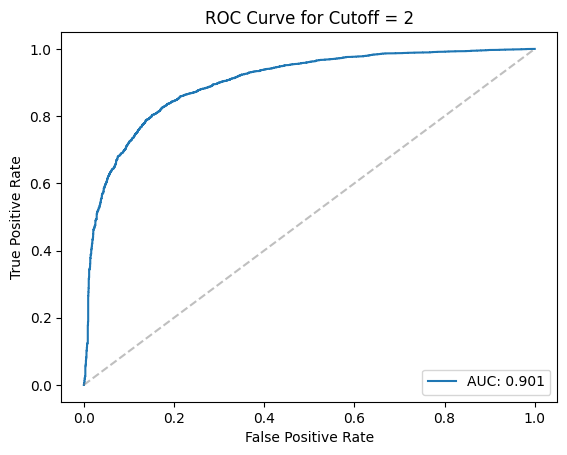

Macro F1 Score: 0.8214761552031657
Cross-Validation Accuracy: 0.8250608497371132
-------------------------
** Cutoff: 3 **
Accuracy: 0.8566289825282631
Params: 0.0, 0.3, 1250, 0.0, 0.3, 1250
Confusion Matrix:
[[3201  375]
 [ 462 1800]]


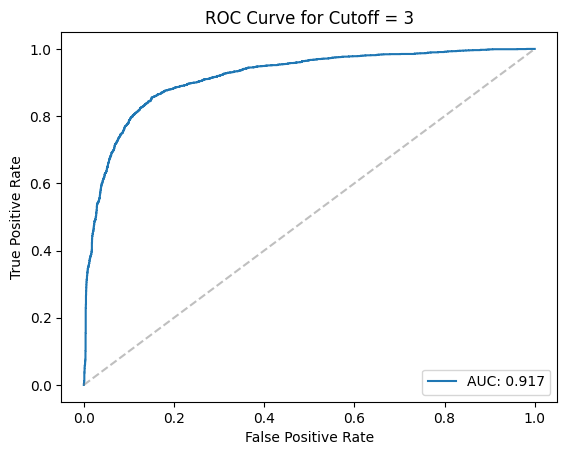

Macro F1 Score: 0.8478676607187741
Cross-Validation Accuracy: 0.8454028478602998
-------------------------
** Cutoff: 4 **
Accuracy: 0.8908872901678657
Params: 0.005, 0.2, 1000, 0.0, 0.2, 500
Confusion Matrix:
[[4467  238]
 [ 399  734]]


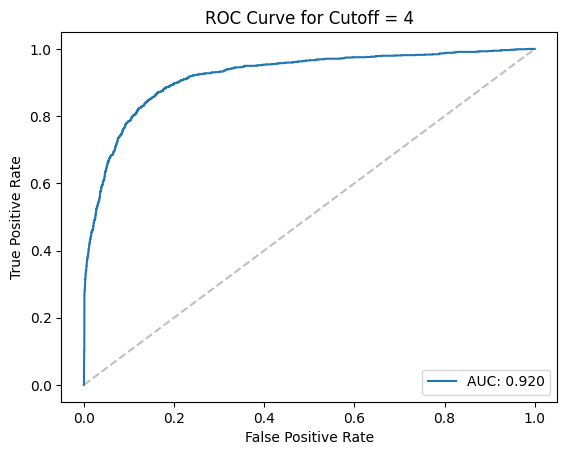

Macro F1 Score: 0.8154159772531382
Cross-Validation Accuracy: 0.8791056484564426
-------------------------


In [1]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, f1_score
from scipy.sparse import hstack
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

def label_rating(row, cutoff):
    if row['overall'] > cutoff:
        return 1  # Good review
    else:
        return 0  # Bad review

# Load the Data
data = pd.read_csv('Training.csv')
testdata = pd.read_csv('Test.csv')

# Preprocess the Data
data = data[['overall', 'reviewText', 'summary', 'verified']]

test_submission1 = pd.DataFrame()
test_submission2 = pd.DataFrame()
test_submission3 = pd.DataFrame()
test_submission4 = pd.DataFrame()

# Split the Data into Training and Testing Sets
cutoff = [1,2,3,4]
for c in cutoff:
    params = pd.read_csv(f'crossval_tuning/crossval_scores_cutoff_{c}.csv').sort_values(by='accuracy', ascending=False).iloc[0]

    rmindf = params['rmindfs']
    rmaxdf = params['rmaxdfs']
    rmaxft = int(params['rmaxfts'])
    smindf = params['smindfs']
    smaxdf = params['smaxdfs']
    smaxft = int(params['smaxfts'])

    data['label'] = data.apply(lambda row: label_rating(row, c), axis=1)

    # Filter out samples with only one class
    grouped_data = data.groupby('label')
    filtered_data = grouped_data.filter(lambda x: len(x) > 1)

    X_train, X_test, y_train, y_test = train_test_split(
        filtered_data[['reviewText', 'summary', 'verified']],
        filtered_data['label'],
        test_size=0.2, random_state=42)

    X_test['summary'] = X_test['summary'].fillna('')
    X_train['summary'] = X_train['summary'].fillna('')

    # Create Feature Vectors using Sklearn Vectorizers

    vectorizer_review = CountVectorizer(min_df=rmindf, max_df=rmaxdf, max_features=rmaxft)
    vectorizer_summary = CountVectorizer(min_df=smindf, max_df=smaxdf, max_features=smaxft)

    X_train_review_vectorized = vectorizer_review.fit_transform(X_train['reviewText'])
    X_train_summary_vectorized = vectorizer_summary.fit_transform(X_train['summary'])
    X_train_verified = X_train['verified'].astype(int).values.reshape(-1, 1)

    X_test_review_vectorized = vectorizer_review.transform(X_test['reviewText'])
    X_test_summary_vectorized = vectorizer_summary.transform(X_test['summary'])
    X_test_verified = X_test['verified'].astype(int).values.reshape(-1, 1)

    # Combine the vectorized features
    X_train_vectorized = hstack([X_train_review_vectorized, X_train_summary_vectorized, X_train_verified])
    X_test_vectorized = hstack([X_test_review_vectorized, X_test_summary_vectorized, X_test_verified])

    # Train and Evaluate the Logistic Regression Model
    model = LogisticRegression()
    model.fit(X_train_vectorized, y_train)

    # Predict labels for the test set
    y_pred = model.predict(X_test_vectorized)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    print(f"** Cutoff: {c} **")
    print(f"Accuracy: {accuracy}")
    print(f'Params: {rmindf}, {rmaxdf}, {rmaxft}, {smindf}, {smaxdf}, {smaxft}')

    # Report Confusion Matrix
    confusion_mat = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(confusion_mat)

    # Report ROC curve and AUC
    y_pred_proba = model.predict_proba(X_test_vectorized)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label = (f'AUC: {roc_auc:.3f}'))
    ax.plot([0, 1], [0, 1], color='gray', alpha = 0.5, linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(F"ROC Curve for Cutoff = {c}")
    plt.legend(loc = "lower right")
    plt.show(block=False)

    # Report Macro F1 Score
    macro_f1 = f1_score(y_test, y_pred, average = 'macro')
    print("Macro F1 Score:", macro_f1)

    # Calculate Accuracy using 5-fold Cross-Validation
    cv_accuracy = cross_val_score(model, X_train_vectorized, y_train, cv=5).mean()
    print("Cross-Validation Accuracy:", cv_accuracy)
    print("-------------------------")

    # Vectorize the test data for prediction
    test_review_vectorized = vectorizer_review.transform(testdata['reviewText'])
    testdata['summary'] = testdata['summary'].fillna('')  # Fill NaN values with empty string
    test_summary_vectorized = vectorizer_summary.transform(testdata['summary'])
    test_verified = testdata['verified'].astype(int).values.reshape(-1, 1)
    test_combined_vectorized = hstack([test_review_vectorized, test_summary_vectorized, test_verified])

    # Predict labels for the test set
    kaggle_test = model.predict(test_combined_vectorized)

    # Generate submission
    test_ids = list(testdata.index)  # the 'id' column name is the index of the test samples
    if c == 1:
        test_submission1 = pd.DataFrame({'id': test_ids, 'binary_split_1': kaggle_test})
    elif c == 2:
        test_submission2 = pd.DataFrame({'id': test_ids, 'binary_split_2': kaggle_test})
    elif c == 3:
        test_submission3 = pd.DataFrame({'id': test_ids, 'binary_split_3': kaggle_test})
    elif c == 4:
        test_submission4 = pd.DataFrame({'id': test_ids, 'binary_split_4': kaggle_test})


In [2]:
test_submission1.to_csv('test_submissions/test_submission_part_1.csv', index=False)
test_submission2.to_csv('test_submissions/test_submission_part_2.csv', index=False)
test_submission3.to_csv('test_submissions/test_submission_part_3.csv', index=False)
test_submission4.to_csv('test_submissions/test_submission_part_4.csv', index=False)

## Multiclassification Task

Confusion Matrix:
[[831 276  66  28  32]
 [279 549 224  63  33]
 [ 91 236 615 194  59]
 [ 43  73 156 628 229]
 [ 36  35  41 171 850]]


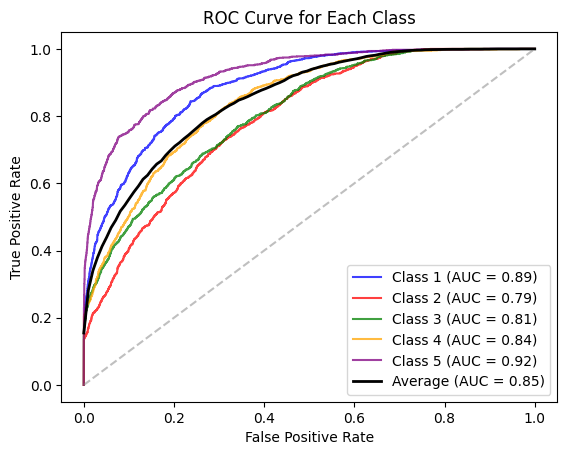

Macro F1 Score: 0.5932051430638416
Accuracy using 5-fold Cross-Validation: 0.5625214224507283


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score
from scipy.sparse import hstack
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load the Data
data = pd.read_csv('Training.csv')
testdata = pd.read_csv('Test.csv')

remove_words =  ['and', 'is', 'was', 'the', 'a', 'an']
pat = '|'.join([r'\b{}\b'.format(w) for w in remove_words])

# Preprocess the Data
data = data[['overall', 'reviewText', 'summary', 'verified']]
data['summary'] = data['summary'].fillna('')
cols = ['reviewText', 'summary']
for c in cols:
    data[c] = data[c].str.lower()
    data[c] = data[c].str.replace(pat, '')

# Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(
    data[['reviewText', 'summary', 'verified']],
    data['overall'],
    test_size=0.2,
    random_state=42)

X_test['summary'] = X_test['summary'].fillna('')
X_train['summary'] = X_train['summary'].fillna('')


# Create Feature Vectors using Sklearn Vectorizers
vectorizer_review = TfidfVectorizer(min_df=30, max_df=12300, max_features=5000)
vectorizer_summary = TfidfVectorizer(min_df=30, max_df=12300, max_features=5000)

X_train_review_vectorized = vectorizer_review.fit_transform(X_train['reviewText'])
X_train_summary_vectorized = vectorizer_summary.fit_transform(X_train['summary'])
X_train_verified = X_train['verified'].astype(int).values.reshape(-1, 1)

X_test_review_vectorized = vectorizer_review.transform(X_test['reviewText'])
X_test_summary_vectorized = vectorizer_summary.transform(X_test['summary'])
X_test_verified = X_test['verified'].astype(int).values.reshape(-1, 1)

# Combine the vectorized features
X_train_vectorized = hstack([X_train_review_vectorized, X_train_summary_vectorized, X_train_verified])
X_test_vectorized = hstack([X_test_review_vectorized, X_test_summary_vectorized, X_test_verified])

# Train and Evaluate the Logistic Regression Model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train_vectorized, y_train)

# Predict labels for the test set
y_pred = model.predict(X_test_vectorized)

# Confusion Matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

# ROC Curve and AUC
y_scores = cross_val_predict(model, X_test_vectorized, y_test, cv=5, method='predict_proba')
fpr = {}
tpr = {}
roc_auc = {}
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_scores[:, i], pos_label=i + 1)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure()
colors = ['blue', 'red', 'green', 'orange', 'purple']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, alpha = 0.75, label='Class {0} (AUC = {1:.2f})'.format(i + 1, roc_auc[i]))

mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)
for i in range(5):
    mean_tpr += np.interp(mean_fpr, fpr[i], tpr[i])
mean_tpr /= 5
mean_auc = auc(mean_fpr, mean_tpr)

# Plot average ROC Curve
plt.plot(mean_fpr, mean_tpr, color='black', lw=2, label='Average (AUC = {0:.2f})'.format(mean_auc))
plt.plot([0, 1], [0, 1], color='gray', alpha = 0.5, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

# Macro F1 Score
f1_macro = f1_score(y_test, y_pred, average='macro')
print("Macro F1 Score:", f1_macro)

# Accuracy using 5-fold cross-validation
accuracy_cv = cross_val_score(model, X_test_vectorized, y_test, cv=5)
print("Accuracy using 5-fold Cross-Validation:", np.mean(accuracy_cv))

# Vectorize the test data for prediction
test_review_vectorized = vectorizer_review.transform(testdata['reviewText'])
testdata['summary'] = testdata['summary'].fillna('')
test_summary_vectorized = vectorizer_summary.transform(testdata['summary'])
test_verified = testdata['verified'].astype(int).values.reshape(-1, 1)
test_combined_vectorized = hstack([test_review_vectorized, test_summary_vectorized, test_verified])

# Predict labels for the test set
kaggle_test = model.predict(test_combined_vectorized)

# Generate submission
test_ids = list(testdata.index)  # the 'id' column name is the index of the test samples
test_submission = pd.DataFrame({'id': test_ids, 'label': kaggle_test})


In [5]:
test_submission
test_submission.to_csv('test_submissions/test_submission_part_5.csv', index=False)

## Clustering Task

In [6]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Load the Data
data = pd.read_csv('Test.csv')

# Preprocess the Data
data['style'].fillna('', inplace=True)  # Fill NA values in 'summary' with empty strings

# Create Feature Vectors using TfidfVectorizer
vectorizer = TfidfVectorizer(min_df = 20, max_df = 0.62, ngram_range =(4,11))
X = vectorizer.fit_transform(data['reviewText'] )

# Perform K-means Clustering
category_labels = data['category']
num_clusters = len(category_labels.unique())

kmeans = KMeans(n_clusters=num_clusters, random_state = 0, init='k-means++')
kmeans.fit(X)

# Evaluate the Clustering Results
silhouette_avg = silhouette_score(X, kmeans.labels_)
rand_index = adjusted_rand_score(category_labels, kmeans.labels_)

print("Silhouette Score:", silhouette_avg)
print("Adjusted Rand Index:", rand_index)


Silhouette Score: 0.9992429539702239
Adjusted Rand Index: 0.00028470788902897564
